In [1]:
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl import load_workbook
# /https://openpyxl.readthedocs.io/
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
# http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

# http://katbailey.github.io/post/gaussian-processes-for-dummies/

In [5]:
wb2 = load_workbook('SampleData_TuberWeight_CatalystAI.xlsx')


In [7]:
df = pd.DataFrame(wb2['Sample Data (training)'].values)
df = df.dropna()
for index, row in df.iterrows():
    if index == 0:
        continue
    row[6] = row[4]**(1/3)
print(df)

            0               1            2                   3  \
0    did_uuid  mid_grade (mm)  tuber count  sample weight (kg)   
1       42269              20           28                0.16   
2       41956              20           21               0.125   
3       41860              20           13                0.08   
4       42221              20            8                0.05   
5       42366              20            9                0.06   
6       42077              20           20               0.135   
7       42125              20           15               0.105   
8       42101              20            4                0.03   
9       42487              20            8                0.06   
10      41836              20           20                0.15   
11      42052              20           12                0.09   
12      42463              20            6                0.05   
13      42245              20            4               0.035   
14      42

In [11]:
mid_grade = np.asarray(df[1][1:])
cube_root = np.asarray(df[6][1:])
print (mid_grade)


[20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30 30
 30 30 30 30 30 30 30 30 30 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40 40
 40 40 40 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 60 60 60
 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60
 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 70 70 70 70 70 70 70 70 70
 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70 70
 70 70 70 70 70 70 70 70 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80 80
 80 80 80 80 80 80 90 90 90 90 90]


In [13]:
import random 

def get_sample():
    mid_grade_to_index = {}
    for i, m in enumerate(mid_grade):
        if m in mid_grade_to_index:
            mid_grade_to_index[m].append(i)
        else:
            mid_grade_to_index[m] = [i]

    mid_grade_sample = []
    cube_root_sample = []

    for mid_grade_ in mid_grade_to_index:
        mid_grade_sample.append(mid_grade_)
        cube_root_sample.append(cube_root[random.sample(mid_grade_to_index[mid_grade_], 1)])

    mid_grade_sample = np.asarray(mid_grade_sample)
    cube_root_sample = np.asarray(cube_root_sample)
    
    return mid_grade_sample, cube_root_sample

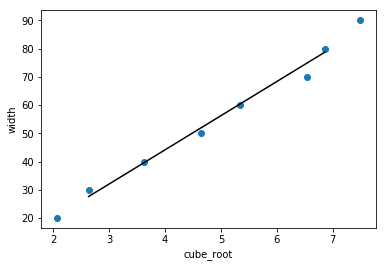

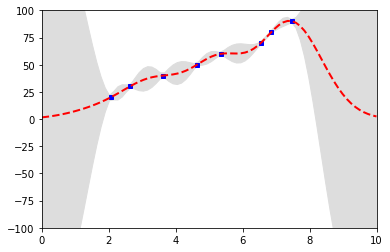

In [14]:
mid_grade_sample, cube_root_sample = get_sample()
regr = linear_model.LinearRegression()
regr.fit(cube_root_sample.reshape(-1, 1), mid_grade_sample.reshape(-1,1))

lin = np.linspace(0, 10, 2).reshape(-1, 1)
regr.predict(lin)

plt.scatter(cube_root_sample, mid_grade_sample)
plt.xlabel('cube_root')
plt.ylabel('width')

regr.predict([cube_root_sample[0], cube_root_sample[-1]])
# print(regr.predict([[cube_root_sample[0]], [cube_root_sample[-1]]))
plt.plot([cube_root_sample[0], cube_root_sample[-1]], regr.predict([cube_root_sample[0], cube_root_sample[-1]]), 'k-')

plt.show()

def kernel(a, b, param=0.1):
    sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
    return np.exp(-0.5 * (1/param) * sqdist)

param = 1.0

Xtrain = np.asarray(cube_root_sample.reshape(-1, 1), dtype=np.float32)
ytrain = np.asarray(mid_grade_sample.reshape(-1, 1), dtype=np.float32)

# Apply the kernel function to our training points
K = kernel(Xtrain, Xtrain, param)
L = np.linalg.cholesky(K + 0.00005*np.eye(len(Xtrain)))

Xtest = np.linspace(0, 10, 80).reshape(-1,1)
n = 80
K_ss = kernel(Xtest, Xtest, param)

# Compute the mean at our test points.
K_s = kernel(Xtrain, Xtest, param)
Lk = np.linalg.solve(L, K_s)
mu = np.dot(Lk.T, np.linalg.solve(L, ytrain)).reshape((n,))

# Compute the standard deviation so we can plot it
s2 = np.diag(K_ss) - np.sum(Lk**2, axis=0)
stdv = 100*np.sqrt(s2)
# Draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ss + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,3)))

plt.plot(Xtrain, ytrain, 'bs', ms=4)
plt.gca().fill_between(Xtest.flat, mu-2*stdv, mu+2*stdv, color="#dddddd")
plt.plot(Xtest, mu, 'r--', lw=2)
plt.axis([0, 10, -100, 100])
plt.show()

In [17]:
print(mid_grade_sample)
print(cube_root_sample)

[80 50 20 70 40 90 60 30]
[[6.857669782774136]
 [4.637287043650982]
 [2.060642652828656]
 [6.543754739925437]
 [3.616684209829249]
 [7.48887230928061]
 [5.342052722000453]
 [2.633341278737126]]
